In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv('df5.tsv', sep="\t")

/h/aashish/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,80,82,103,104,105,106,107,108,111,112,113,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.columns

Index([u'Unnamed: 0', u'#chr', u'pos', u'ref', u'alt', u'gene', u'value',
       u'confidence', u'WhatSet', u'ConsScore',
       ...
       u'meanH4K8ac', u'meanH4K91ac', u'meanDNase.hotspot.all',
       u'meanDNase.hotspot.fdr0.01', u'meanRoadmap', u'valuec', u'Trimer',
       u'TrimerAvg', u'TrimerMut', u'Tetra'],
      dtype='object', length=162)

In [5]:
#df['WhatSet']

In [6]:
#df.columns

In [7]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics

numeric_feats = df.dtypes[df.dtypes != "object"].index - ['value','confidence','valuec','pos']
cat_feats =  df.dtypes[df.dtypes == "object"].index
#numeric_featst = df.dtypes[dft2.dtypes != "object"].index

/h/aashish/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  after removing the cwd from sys.path.


In [8]:
len(numeric_feats)

113

In [9]:
len(cat_feats)

45

In [10]:
from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute
X = KNN(k=3).complete(df[numeric_feats])
#Xt= KNN(k=3).complete(dft2[numeric_featst])

/h/aashish/.local/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Imputing row 1/17061 with 11 missing, elapsed time: 182.713
Imputing row 101/17061 with 8 missing, elapsed time: 182.764
Imputing row 201/17061 with 10 missing, elapsed time: 182.815
Imputing row 301/17061 with 10 missing, elapsed time: 182.933
Imputing row 401/17061 with 10 missing, elapsed time: 183.012
Imputing row 501/17061 with 11 missing, elapsed time: 183.080
Imputing row 601/17061 with 13 missing, elapsed time: 183.150
Imputing row 701/17061 with 11 missing, elapsed time: 183.220
Imputing row 801/17061 with 12 missing, elapsed time: 183.310
Imputing row 901/17061 with 11 missing, elapsed time: 183.396
Imputing row 1001/17061 with 9 missing, elapsed time: 183.449
Imputing row 1101/17061 with 9 missing, elapsed time: 183.503
Imputing row 1201/17061 with 13 missing, elapsed time: 183.561
Imputing row 1301/17061 with 28 missing, elapsed time: 183.686
Imputing row 1401/17061 with 28 missing, elapsed time: 183.861
Imputing row 1501/17061 with 26 missing, elapsed time: 184.032
Imputin

In [11]:
X2=pd.DataFrame(data=X, columns=df[numeric_feats].columns, index=df[numeric_feats].index)
#Xt2=pd.DataFrame(data=Xt, columns=dft2[numeric_featst].columns, index=dft2[numeric_featst].index)
#y=df['value']
#yc=df['valec']
labelX=['WhatSet','#chr', 'pos', 'ref','alt','gene']
vals=['value','valuec','confidence']
X3=X2.join(df[labelX+vals])

In [13]:
trainset=X3[X3['WhatSet']=="Train"]
X4train=trainset[numeric_feats]
testset=X3[X3['WhatSet']=="Test"]
X4test=testset[numeric_feats]
y=trainset['value']
yc=trainset['valuec']
conf=trainset['confidence']

In [14]:
import numpy as np
import pandas as pd

from hyperopt import hp, tpe
from hyperopt.fmin import fmin

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer

import xgboost as xgb

import lightgbm as lgbm

def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
    }
    
    clf = xgb.XGBClassifier(
        n_estimators=250,
        learning_rate=0.05,
        n_jobs=4,
        **params
    )
    
    score = cross_val_score(clf, X4train, yc, scoring='roc_auc', cv=StratifiedKFold()).mean()
    print("Gini {:.3f} params {}".format(score, params))
    return score

space = {
    'max_depth': hp.quniform('max_depth', 2, 20, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'gamma': hp.uniform('gamma', 0.0, 0.5),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

Gini 0.502 params {'colsample_bytree': '0.871', 'max_depth': 6, 'gamma': '0.370'}
Gini 0.500 params {'colsample_bytree': '0.499', 'max_depth': 10, 'gamma': '0.456'}
Gini 0.495 params {'colsample_bytree': '0.864', 'max_depth': 6, 'gamma': '0.143'}
Gini 0.501 params {'colsample_bytree': '0.409', 'max_depth': 7, 'gamma': '0.132'}
Gini 0.504 params {'colsample_bytree': '0.510', 'max_depth': 13, 'gamma': '0.293'}
Gini 0.501 params {'colsample_bytree': '0.353', 'max_depth': 18, 'gamma': '0.028'}
Gini 0.510 params {'colsample_bytree': '0.617', 'max_depth': 17, 'gamma': '0.353'}
Gini 0.501 params {'colsample_bytree': '0.865', 'max_depth': 19, 'gamma': '0.460'}
Gini 0.514 params {'colsample_bytree': '0.821', 'max_depth': 17, 'gamma': '0.130'}
Gini 0.505 params {'colsample_bytree': '0.376', 'max_depth': 11, 'gamma': '0.142'}
Gini 0.509 params {'colsample_bytree': '0.593', 'max_depth': 19, 'gamma': '0.443'}
Gini 0.498 params {'colsample_bytree': '0.696', 'max_depth': 16, 'gamma': '0.330'}
Gini 0.

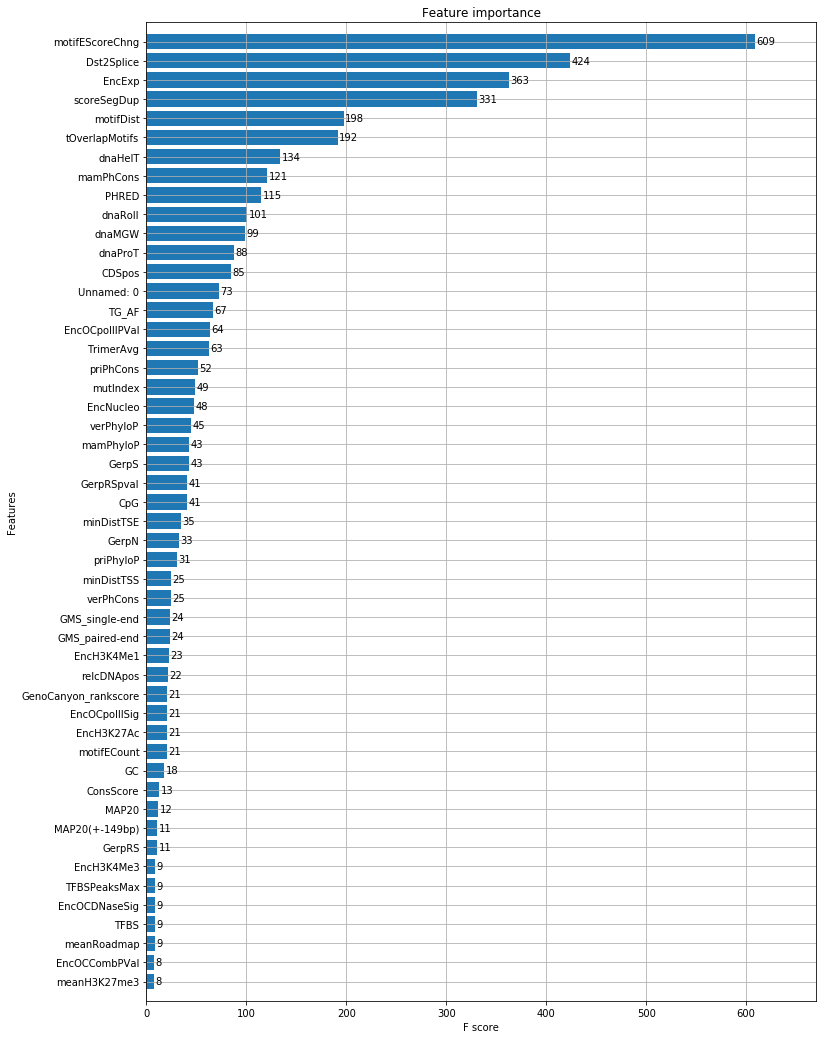

In [15]:
# plot the important features #

dtrain = xgb.DMatrix(X4train, yc, feature_names=X4train.columns.values)
model = xgb.train(dict(params=best, silent=0), dtrain, num_boost_round=150)

fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [16]:
from xgboost import XGBClassifier

xgbcl = XGBClassifier(n_estimators=14, seed=41)
xgbcl.fit(X4train, yc)
print(xgbcl.score(X4train, yc))

0.6370786516853932


/h/aashish/.local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [77]:
#xgbcl.predict(X4test)

In [73]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
    }
    
    clf = lgbm.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.01,
        **params
    )
    
    score = cross_val_score(clf, X4train, yc, scoring='roc_auc', cv=StratifiedKFold()).mean()
    print("Gini {:.3f} params {}".format(score, params))
    return score

space = {
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

Gini 0.513 params {'num_leaves': 22, 'colsample_bytree': '0.872'}
Gini 0.502 params {'num_leaves': 82, 'colsample_bytree': '0.455'}
Gini 0.508 params {'num_leaves': 94, 'colsample_bytree': '0.833'}
Gini 0.507 params {'num_leaves': 124, 'colsample_bytree': '0.559'}
Gini 0.513 params {'num_leaves': 28, 'colsample_bytree': '0.825'}
Gini 0.501 params {'num_leaves': 86, 'colsample_bytree': '0.957'}
Gini 0.507 params {'num_leaves': 28, 'colsample_bytree': '0.446'}
Gini 0.508 params {'num_leaves': 22, 'colsample_bytree': '0.462'}
Gini 0.505 params {'num_leaves': 32, 'colsample_bytree': '0.579'}
Gini 0.501 params {'num_leaves': 16, 'colsample_bytree': '0.388'}


In [ ]:
#Bayesopt

In [17]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold

# SETTINGS - CHANGE THESE TO GET SOMETHING MEANINGFUL
ITERATIONS = 100 # 1000
#TRAINING_SIZE = 100000 # 20000000
#TEST_SIZE = 25000


In [18]:
# Classifier
bayes_cv_tuner = BayesSearchCV(
    estimator = xgb.XGBClassifier(
        n_jobs = 1,
        objective = 'binary:logistic',
        eval_metric = 'auc',
        silent=1,
        tree_method='approx'
    ),
    search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 10),
        'max_depth': (0, 50),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'gamma': (1e-9, 0.5, 'log-uniform'),
        'min_child_weight': (0, 5),
        'n_estimators': (50, 100),
        'scale_pos_weight': (1e-6, 500, 'log-uniform')
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=42
    ),
    n_jobs = 3,
    n_iter = ITERATIONS,   
    verbose = 0,
    refit = True,
    random_state = 42
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

In [84]:
result = bayes_cv_tuner.fit(X4train.values, yc, callback=status_print)

Model #1
Best ROC-AUC: 0.6033
Best params: {'reg_alpha': 5.497557739289786e-07, 'colsample_bytree': 0.7304484857455519, 'colsample_bylevel': 0.4160029192647807, 'scale_pos_weight': 0.060830282487222144, 'learning_rate': 0.042815319280763466, 'max_delta_step': 13, 'min_child_weight': 2, 'n_estimators': 87, 'subsample': 0.13556548021189216, 'reg_lambda': 0.05936070635912049, 'max_depth': 21, 'gamma': 0.13031389926541354}

Model #2
Best ROC-AUC: 0.6354
Best params: {'reg_alpha': 0.0005266983003701547, 'colsample_bytree': 0.8844821246070537, 'colsample_bylevel': 0.8390144719977516, 'scale_pos_weight': 0.3016410771843142, 'learning_rate': 0.7988179462781242, 'max_delta_step': 17, 'min_child_weight': 1, 'n_estimators': 68, 'subsample': 0.9923710598637134, 'reg_lambda': 276.5424475574225, 'max_depth': 3, 'gamma': 4.358684608480795e-07}

Model #3
Best ROC-AUC: 0.6373
Best params: {'reg_alpha': 0.00010376808625045426, 'colsample_bytree': 0.9195352964526833, 'colsample_bylevel': 0.45038418717814

In [105]:
bestp={'reg_alpha': 0.0003083822914460526, 'colsample_bytree': 0.40951790014616496, 'colsample_bylevel': 1.0, 'scale_pos_weight': 2.530219583129893, 'learning_rate': 0.01, 'max_delta_step': 13, 'min_child_weight': 3, 'n_estimators': 73, 'subsample': 0.6259354350915352, 'reg_lambda': 2.6696222945711226e-06, 'max_depth': 50, 'gamma': 0.02223945990963383}
orip={'reg_alpha': 5.497557739289786e-07, 'colsample_bytree': 0.7304484857455519, 'colsample_bylevel': 0.4160029192647807, 'scale_pos_weight': 0.060830282487222144, 'learning_rate': 0.042815319280763466, 'max_delta_step': 13, 'min_child_weight': 2, 'n_estimators': 87, 'subsample': 0.13556548021189216, 'reg_lambda': 0.05936070635912049, 'max_depth': 21, 'gamma': 0.13031389926541354}

clf2=xgb.XGBClassifier()
clf2.set_params(**bestp)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=0.409517900146, gamma=0.0222394599096,
       learning_rate=0.01, max_delta_step=13, max_depth=50,
       min_child_weight=3, missing=None, n_estimators=73, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.000308382291446, reg_lambda=2.66962229457e-06,
       scale_pos_weight=2.53021958313, seed=None, silent=True,
       subsample=0.625935435092)

In [106]:
cross_val_score(clf2, X4train, yc, scoring='roc_auc', cv=StratifiedKFold()).mean()

0.49883810693509617

In [110]:
clf2.fit(X4train,yc)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=0.409517900146, gamma=0.0222394599096,
       learning_rate=0.01, max_delta_step=13, max_depth=50,
       min_child_weight=3, missing=None, n_estimators=73, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.000308382291446, reg_lambda=2.66962229457e-06,
       scale_pos_weight=2.53021958313, seed=None, silent=True,
       subsample=0.625935435092)

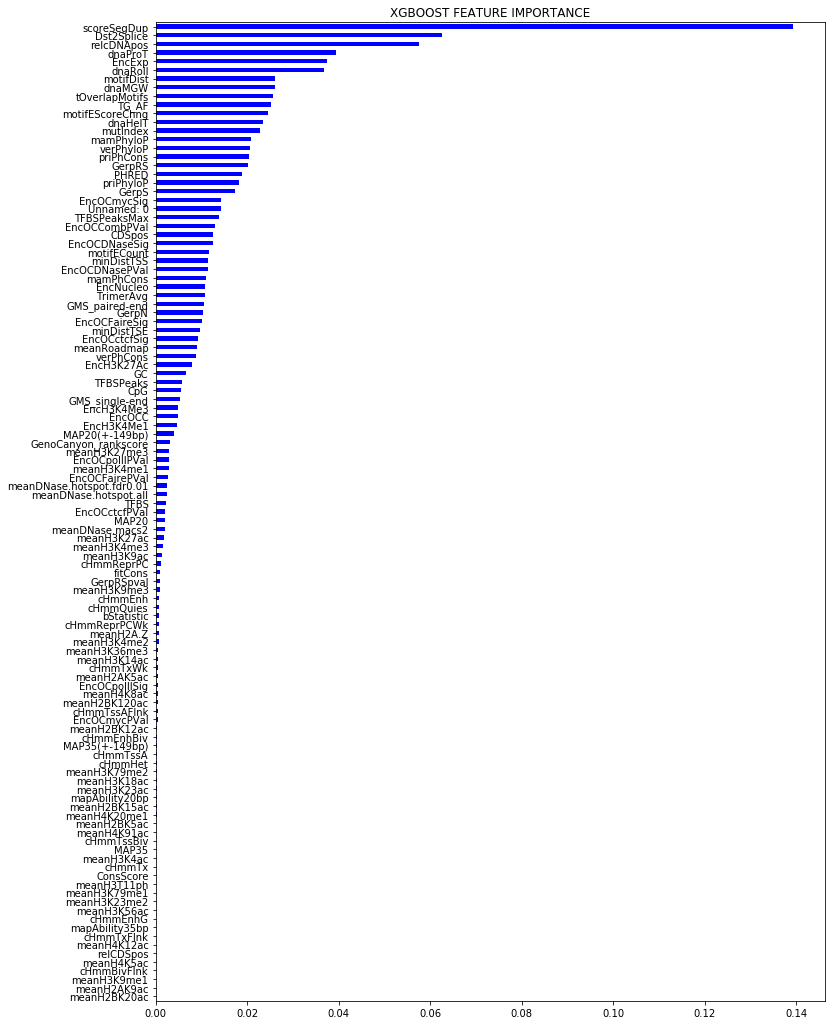

In [111]:
pd.Series(clf2.feature_importances_,index=list(X4train.columns.values)).sort_values(ascending=True).plot(kind='barh',figsize=(12,18),title='XGBOOST FEATURE IMPORTANCE')

In [132]:
#testset[['#chr','ref','alt', 'gene', 'pred']]

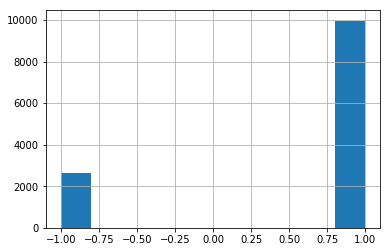

In [129]:
#['pred'].hist()

/h/aashish/.local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


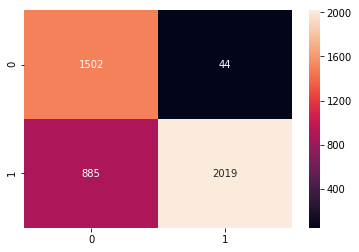

In [133]:
from sklearn.metrics import confusion_matrix #for confusion matrix
sns.heatmap(confusion_matrix(clf2.predict(X4train),yc),annot=True,fmt='2.0f')

In [19]:
from scipy import stats
from sklearn.metrics import make_scorer
from matplotlib import rcParams

def pears(y_true,y_pred):
    return stats.pearsonr(y_true, y_pred)[0]
pscorer = make_scorer(pears)  

In [73]:
# Classifier
ITERATIONS=100
bayes_cv_tuner_regression = BayesSearchCV(
    estimator = xgb.XGBRegressor(
        n_jobs = 1,
        objective = 'reg:linear',
        #eval_metric = stats.pearsonr,
        #eval_metric ='rmse',
        silent=1,
        tree_method='approx'
    ),
    search_spaces = {
        'learning_rate': (0.001, 0.1, 'log-uniform'),
        'min_child_weight': (1, 12),
        'max_depth': (5, 50),
        'max_delta_step': (1, 30),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        #'gamma':0,
        'min_child_weight': (1, 10),
        'n_estimators': (50, 150),
        'scale_pos_weight': (1e-6, 500, 'log-uniform')
    },    
   scoring =pscorer,
   # cv = StratifiedKFold(
   #     n_splits=3,
   #     shuffle=True,
   #     random_state=42
   # ),
    n_jobs = 3,
    n_iter = ITERATIONS,   
    verbose = 0,
    refit = True,
    random_state = 91
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner_regression.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner_regression.best_params_)
    print('Model #{}\nBest Pearson: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner_regression.best_score_, 4),
        bayes_cv_tuner_regression.best_params_
    ))
    
    # Save all model results
    #clf_name = bayes_cv_tuner.estimator.__class__.__name__
    #all_models.to_csv(clf_name+"_cv_results.csv")

In [74]:
result = bayes_cv_tuner_regression.fit(X4train.fillna(0).values, y, callback=status_print)

Model #1
Best Pearson: -0.0681
Best params: {'reg_alpha': 0.004880088101142988, 'colsample_bytree': 0.7501873035256915, 'colsample_bylevel': 0.21582389045274647, 'scale_pos_weight': 189.61482064978577, 'learning_rate': 0.007937453029890112, 'max_delta_step': 4, 'min_child_weight': 7, 'n_estimators': 59, 'subsample': 0.2246776823331267, 'reg_lambda': 2.1158031553224714e-05, 'max_depth': 31}

Model #2
Best Pearson: 0.073
Best params: {'reg_alpha': 7.071045355749024e-08, 'colsample_bytree': 0.8389492413477709, 'colsample_bylevel': 0.9961229924022005, 'scale_pos_weight': 2.035553597263256e-05, 'learning_rate': 0.06669678373921058, 'max_delta_step': 2, 'min_child_weight': 6, 'n_estimators': 51, 'subsample': 0.026875945995863737, 'reg_lambda': 1.8042134254093527e-05, 'max_depth': 43}

Model #3
Best Pearson: 0.0804
Best params: {'reg_alpha': 0.00012911845587880747, 'colsample_bytree': 0.5744005534470272, 'colsample_bylevel': 0.6406921363817413, 'scale_pos_weight': 0.004047867121163358, 'learn

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

(0.7213486638604132, 2.6446701548811697e-236)


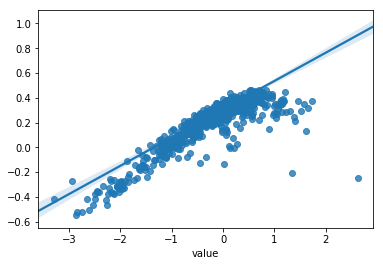

/h/aashish/.local/lib/python2.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,#chr,pos,ref,alt,gene,predictions
4450,1,109817274,G,A,SORT1,0.262665
4451,1,109817274,G,C,SORT1,0.262348
4452,1,109817274,G,T,SORT1,0.257472
4453,1,109817275,A,C,SORT1,0.267851
4454,1,109817275,A,G,SORT1,0.277245
4455,1,109817275,A,T,SORT1,0.270577
4456,1,109817276,A,C,SORT1,0.266590
4457,1,109817276,A,G,SORT1,0.273077
4458,1,109817276,A,T,SORT1,0.271615
4459,1,109817277,C,A,SORT1,0.265323


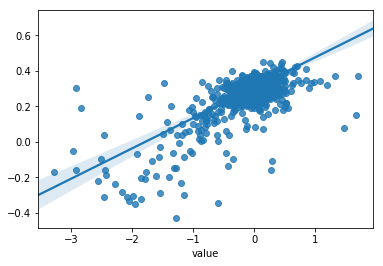

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X4train, y, test_size=0.33, random_state=42)
#xgbx = xgb.XGBRegressor(n_estimators=100, learning_rate=0.01, gamma=0, subsample=0.75,colsample_bytree=1, max_depth=20)

#bestx={'reg_alpha': 1.4015400748491145e-05, 'colsample_bytree': 0.9977035648022329, 'colsample_bylevel': 0.01, 'scale_pos_weight': 0.002548744759772462, 'learning_rate': 0.03720103487827347, 'max_delta_step': 5, 'min_child_weight': 3, 'n_estimators': 52, 'subsample': 0.8466493694000479, 'reg_lambda': 1000.0, 'max_depth': 7, 'gamma': 0}
#bestx={'reg_alpha': 7.2242936880276095e-06, 'colsample_bytree': 0.27886717784463166, 'colsample_bylevel': 0.8532877332366651, 'scale_pos_weight': 0.04389853270050046, 'learning_rate': 0.004001479055961545, 'max_delta_step': 18, 'min_child_weight': 0, 'n_estimators': 86, 'subsample': 0.646686594004936, 'reg_lambda': 2.5946074090141028e-08, 'max_depth': 23}
#bestx= {'reg_alpha': 0.002075991495913999, 'colsample_bytree': 0.19236120678504934, 'colsample_bylevel': 0.47800539806387743, 'scale_pos_weight': 0.0011525475234244451, 'learning_rate': 0.0035838212966189976, 'max_delta_step': 4, 'min_child_weight': 1, 'n_estimators': 139, 'subsample': 0.7161795341594297, 'reg_lambda': 0.021592354178588413, 'max_depth': 27}
bestx={'reg_alpha': 0.002075991495913999, 'colsample_bytree': 0.19236120678504934, 'colsample_bylevel': 0.47800539806387743, 'scale_pos_weight': 0.0011525475234244451, 'learning_rate': 0.0030326656215075728, 'max_delta_step': 7, 'min_child_weight': 2, 'n_estimators': 139, 'subsample': 0.7161795341594297, 'reg_lambda': 0.021592354178588413, 'max_depth': 27}



xgbx=xgb.XGBRegressor()

xgbx.set_params(**bestx)

xgbx.fit(X_train,y_train)
print stats.pearsonr(y_test,xgbx.predict(X_test))
sns.regplot(x=y_train,y=xgbx.predict(X_train))
plt.show()
sns.regplot(x=y_test,y=xgbx.predict(X_test))
predictions=xgbx.predict(X4test)
testset['predictions']=predictions
testset[['#chr', 'pos', 'ref','alt','gene', 'predictions']]

In [77]:
xgbx.fit(X4train,y)
#print stats.pearsonr(y_test,xgbx.predict(X_test))
#sns.regplot(x=y_train,y=xgbx.predict(X_train))
#plt.show()
#sns.regplot(x=y_test,y=xgbx.predict(X_test))
predictions=xgbx.predict(X4test)
testset['predictions']=predictions

xgbx.fit(X4train,conf)
std=xgbx.predict(X4test)
testset['stdev']=std

testset[['#chr', 'pos', 'ref','alt','gene', 'predictions']]

/h/aashish/.local/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/h/aashish/.local/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,#chr,pos,ref,alt,gene,predictions
4450,1,109817274,G,A,SORT1,0.263037
4451,1,109817274,G,C,SORT1,0.262904
4452,1,109817274,G,T,SORT1,0.259216
4453,1,109817275,A,C,SORT1,0.281183
4454,1,109817275,A,G,SORT1,0.278194
4455,1,109817275,A,T,SORT1,0.276844
4456,1,109817276,A,C,SORT1,0.281088
4457,1,109817276,A,G,SORT1,0.275099
4458,1,109817276,A,T,SORT1,0.265181
4459,1,109817277,C,A,SORT1,0.267967


In [81]:
testset[['#chr', 'pos', 'ref','alt','gene', 'predictions','stdev']]

,#chr,pos,ref,alt,gene,predictions,stdev
4450,1,109817274,G,A,SORT1,0.263037,0.342584
4451,1,109817274,G,C,SORT1,0.262904,0.341976
4452,1,109817274,G,T,SORT1,0.259216,0.343533
4453,1,109817275,A,C,SORT1,0.281183,0.342102
4454,1,109817275,A,G,SORT1,0.278194,0.342116
4455,1,109817275,A,T,SORT1,0.276844,0.342458
4456,1,109817276,A,C,SORT1,0.281088,0.341267
4457,1,109817276,A,G,SORT1,0.275099,0.341963
4458,1,109817276,A,T,SORT1,0.265181,0.342554
4459,1,109817277,C,A,SORT1,0.267967,0.341857


XGBRegressor(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.478005398064, colsample_bytree=0.192361206785,
       gamma=0, learning_rate=0.00358382129662, max_delta_step=4,
       max_depth=27, min_child_weight=1, missing=None, n_estimators=139,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.00207599149591, reg_lambda=0.0215923541786,
       scale_pos_weight=0.00115254752342, seed=None, silent=True,
       subsample=0.716179534159)

(0.7202246806424141, 3.1428924501284626e-235)

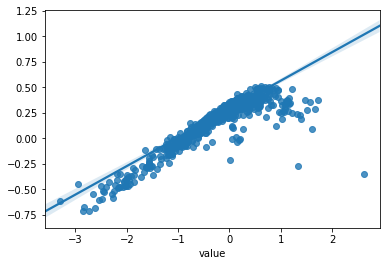

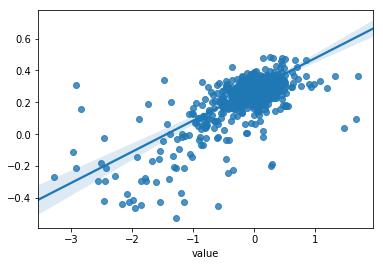

(array([5.000e+00, 1.500e+01, 4.100e+01, 7.100e+01, 9.900e+01, 2.230e+02,
        4.120e+02, 1.963e+03, 9.462e+03, 3.200e+02]),
 array([-0.30979782, -0.24128042, -0.17276301, -0.10424561, -0.0357282 ,
         0.0327892 ,  0.10130661,  0.16982401,  0.23834141,  0.30685882,
         0.37537622]),
 <a list of 10 Patch objects>)

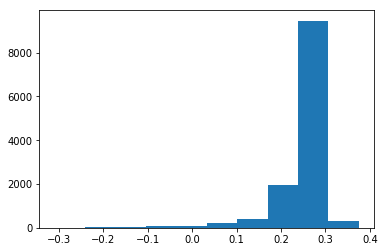

In [28]:
#plt.hist(xgbx.predict(X4test))

/h/aashish/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,#chr,pos,ref,alt,gene,predictions
4450,1,109817274,G,A,SORT1,0.257858
4451,1,109817274,G,C,SORT1,0.253284
4452,1,109817274,G,T,SORT1,0.254587
4453,1,109817275,A,C,SORT1,0.245337
4454,1,109817275,A,G,SORT1,0.242043
4455,1,109817275,A,T,SORT1,0.239971
4456,1,109817276,A,C,SORT1,0.240542
4457,1,109817276,A,G,SORT1,0.247053
4458,1,109817276,A,T,SORT1,0.240400
4459,1,109817277,C,A,SORT1,0.257176


In [70]:
from lightgbm import LGBMRegressor
ITERATIONS=100
bayes_cv_tuner_regression  = BayesSearchCV(
  estimator=LGBMRegressor(objective='regression'),
       search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'num_leaves': (20, 200),      
        'max_depth': (1, 100),
        'min_child_samples': (20, 100),
        'max_bin': (100, 1000),
        'subsample': (0.01, 1.0, 'uniform'),
        'subsample_freq': (1, 20),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'min_child_weight': (1, 30),
        'subsample_for_bin': (1000, 5000),
        #'reg_lambda': (1e-9, 1000, 'log-uniform'),
        #'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'scale_pos_weight': (1e-6, 500, 'log-uniform'),
        'n_estimators': (50, 500),
    }, 
   scoring =pscorer,
   # cv = StratifiedKFold(
   #     n_splits=3,
   #     shuffle=True,
   #     random_state=42
   # ),
    n_jobs = 3,
    n_iter = ITERATIONS,   
    verbose = 0,
    refit = True,
    random_state = 44
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner_regression.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner_regression.best_params_)
    print('Model #{}\nBest Pearson: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner_regression.best_score_, 4),
        bayes_cv_tuner_regression.best_params_
    ))
    
    # Save all model results
    #clf_name = bayes_cv_tuner.estimator.__class__.__name__
    #all_models.to_csv(clf_name+"_cv_results.csv")

In [71]:
result = bayes_cv_tuner_regression.fit(X4train.fillna(0).values, y, callback=status_print)

Model #1
Best Pearson: -0.0051
Best params: {'num_leaves': 89, 'subsample_for_bin': 2547, 'colsample_bytree': 0.19828518924621577, 'scale_pos_weight': 2.5106685814924e-06, 'learning_rate': 0.3527216683412572, 'min_child_weight': 2, 'max_depth': 18, 'n_estimators': 246, 'subsample': 0.9232226824475199, 'subsample_freq': 3, 'max_bin': 165, 'min_child_samples': 63}

Model #2
Best Pearson: 0.1068
Best params: {'num_leaves': 162, 'subsample_for_bin': 4465, 'colsample_bytree': 0.4647917363261662, 'scale_pos_weight': 88.32405650640456, 'learning_rate': 0.013054277272783308, 'min_child_weight': 1, 'max_depth': 16, 'n_estimators': 61, 'subsample': 0.39508392563007166, 'subsample_freq': 19, 'max_bin': 170, 'min_child_samples': 23}

Model #3
Best Pearson: 0.1068
Best params: {'num_leaves': 162, 'subsample_for_bin': 4465, 'colsample_bytree': 0.4647917363261662, 'scale_pos_weight': 88.32405650640456, 'learning_rate': 0.013054277272783308, 'min_child_weight': 1, 'max_depth': 16, 'n_estimators': 61, 

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [82]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X4train, y, test_size=0.33, random_state=42)
#xgbx = xgb.XGBRegressor(n_estimators=100, learning_rate=0.01, gamma=0, subsample=0.75,colsample_bytree=1, max_depth=20)

#bestx={'reg_alpha': 1.4015400748491145e-05, 'colsample_bytree': 0.9977035648022329, 'colsample_bylevel': 0.01, 'scale_pos_weight': 0.002548744759772462, 'learning_rate': 0.03720103487827347, 'max_delta_step': 5, 'min_child_weight': 3, 'n_estimators': 52, 'subsample': 0.8466493694000479, 'reg_lambda': 1000.0, 'max_depth': 7, 'gamma': 0}
#bestx={'reg_alpha': 7.2242936880276095e-06, 'colsample_bytree': 0.27886717784463166, 'colsample_bylevel': 0.8532877332366651, 'scale_pos_weight': 0.04389853270050046, 'learning_rate': 0.004001479055961545, 'max_delta_step': 18, 'min_child_weight': 0, 'n_estimators': 86, 'subsample': 0.646686594004936, 'reg_lambda': 2.5946074090141028e-08, 'max_depth': 23}
#bestx= {'reg_alpha': 0.002075991495913999, 'colsample_bytree': 0.19236120678504934, 'colsample_bylevel': 0.47800539806387743, 'scale_pos_weight': 0.0011525475234244451, 'learning_rate': 0.0035838212966189976, 'max_delta_step': 4, 'min_child_weight': 1, 'n_estimators': 139, 'subsample': 0.7161795341594297, 'reg_lambda': 0.021592354178588413, 'max_depth': 27}
#bestx= {'num_leaves': 20, ' min_sum_hessian_in_leaf': 6, 'learning_rate': 0.015354636727224329, 'min_data_in_leaf': 13, 'max_bin': 57, 'bagging_fraction': 0.9754628853729429, ' bagging_freq': 13, 'feature_fraction': 0.1953341127646401}
#bestx={'num_leaves': 44, 'reg_alpha': 1e-09, 'subsample_freq': 5, 'colsample_bytree': 0.5603967605939404, 'scale_pos_weight': 0.6098937051650142, 'learning_rate': 0.03189716214742334, 'min_child_weight': 9, 'max_depth': 100, 'n_estimators': 20, 'subsample': 1.0, 'reg_lambda': 0.00017720534879329798, 'max_bin': 1000, 'min_child_samples': 100}
#bestx= {'num_leaves': 198, 'reg_alpha': 0.00019491574307683936, 'subsample_for_bin': 3304, 'colsample_bytree': 0.5350260583708334, 'scale_pos_weight': 0.00018591844592272225, 'learning_rate': 0.016898372169223505, 'min_child_weight': 9, 'max_depth': 41, 'n_estimators': 40, 'subsample': 0.39060588478441904, 'reg_lambda': 1.599241051420147, 'subsample_freq': 12, 'max_bin': 764, 'min_child_samples': 74}
bestx= {'num_leaves': 198, 'subsample_for_bin': 2043, 'colsample_bytree': 0.5350260583708334, 'scale_pos_weight': 0.12969203244195532, 'learning_rate': 0.016898372169223505, 'min_child_weight': 9, 'max_depth': 41, 'n_estimators': 100, 'subsample': 0.7693228991667892, 'subsample_freq': 8, 'max_bin': 764, 'min_child_samples': 79}
xgbx=LGBMRegressor()
xgbx.set_params(**bestx)

# xgbx.fit(X_train,y_train)
# print stats.pearsonr(y_test,xgbx.predict(X_test))
# sns.regplot(x=y_train,y=xgbx.predict(X_train))
# plt.show()
# sns.regplot(x=y_test,y=xgbx.predict(X_test))
# predictions=xgbx.predict(X4test)
# testset['predictions2']=predictions
# testset[['#chr', 'pos', 'ref','alt','gene', 'predictions', 'predictions2']]

xgbx.fit(X4train,y)
#print stats.pearsonr(y_test,xgbx.predict(X_test))
#sns.regplot(x=y_train,y=xgbx.predict(X_train))
#plt.show()
#sns.regplot(x=y_test,y=xgbx.predict(X_test))
predictions=xgbx.predict(X4test)
testset['predictions2']=predictions

xgbx.fit(X4train,conf)
std=xgbx.predict(X4test)
testset['stdev2']=std

testset[['#chr', 'pos', 'ref','alt','gene', 'predictions','stdev','predictions2','stdev2']]

/h/aashish/.local/lib/python2.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/h/aashish/.local/lib/python2.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,#chr,pos,ref,alt,gene,predictions,stdev,predictions2,stdev2
4450,1,109817274,G,A,SORT1,0.263037,0.342584,-0.084277,0.097616
4451,1,109817274,G,C,SORT1,0.262904,0.341976,-0.069704,0.076254
4452,1,109817274,G,T,SORT1,0.259216,0.343533,-0.075655,0.084167
4453,1,109817275,A,C,SORT1,0.281183,0.342102,-0.078223,0.075240
4454,1,109817275,A,G,SORT1,0.278194,0.342116,-0.082293,0.105681
4455,1,109817275,A,T,SORT1,0.276844,0.342458,-0.083951,0.082323
4456,1,109817276,A,C,SORT1,0.281088,0.341267,-0.056496,0.086376
4457,1,109817276,A,G,SORT1,0.275099,0.341963,-0.064261,0.106045
4458,1,109817276,A,T,SORT1,0.265181,0.342554,-0.055972,0.080786
4459,1,109817277,C,A,SORT1,0.267967,0.341857,-0.101942,0.146511


In [83]:
out=testset[['#chr', 'pos', 'ref','alt','gene', 'predictions','stdev','predictions2','stdev2']]

In [96]:
out['pval']=out['predictions']-out['predictions2']
out['cval']=out['stdev']-out['stdev2']

/h/aashish/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/h/aashish/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [97]:
#out['pval2'] = out['pval'].div(out.pval.sum())
#out['cval2'] = out['cval'].div(out.cval.sum())

/h/aashish/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/h/aashish/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [105]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

out['pval2'] = min_max_scaler.fit_transform(out[['pval']].values)
out['cval2'] = min_max_scaler.fit_transform(out[['cval']].values)
#df = pandas.DataFrame(x_scaled)

/h/aashish/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/h/aashish/.local/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [107]:
out[['#chr','pos','ref','alt','gene','predictions','pval2','stdev','cval2']].to_csv('Predictions/Pred_XGBOOST.tsv',sep="\t")

In [109]:
len(out[out['predictions']>0])

12473

In [110]:
len(X4train[X4train['value']>0])

KeyError: 'value'

In [ ]:
c

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV


import numpy as np
import pandas as pd

from hyperopt import hp, tpe
from hyperopt.fmin import fmin

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer

import xgboost as xgb
import lightgbm as lgbm

from sklearn.linear_model import LassoCV

from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline


alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
kfolds = KFold(n_splits=10, shuffle=True, random_state=23)
alphas = [0.00005, 0.0001, 0.0003, 0.0005, 0.0007, 
          0.0009, 0.01]
alphas2 = [0.00005, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
           0.0006, 0.0007, 0.0008]

from sklearn.linear_model import ElasticNetCV
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

lasso_model2 = make_pipeline(RobustScaler(),
                             LassoCV(max_iter=1e7,
                                    alphas = alphas2,
                                    random_state = 42)).fit(X4train, y)

scores = lasso_model2.steps[1][1].mse_path_

#setup models
ridge = make_pipeline(RobustScaler(), 
                      RidgeCV(alphas = alphas_alt, cv=kfolds))

lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas = alphas2,
                              random_state = 42, cv=kfolds))

elasticnet = make_pipeline(RobustScaler(), 
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas, 
                                        cv=kfolds, l1_ratio=e_l1ratio))

lightgbm = make_pipeline(RobustScaler(),
                        LGBMRegressor(objective='regression',num_leaves=5,
                                      learning_rate=0.05, n_estimators=720,
                                      max_bin = 55, bagging_fraction = 0.8,
                                      bagging_freq = 5, feature_fraction = 0.2319,
                                      feature_fraction_seed=9, bagging_seed=9,
                                      min_data_in_leaf =6, 
                                      min_sum_hessian_in_leaf = 11))

xgboost = make_pipeline(RobustScaler(),
                        XGBRegressor(learning_rate =0.01, n_estimators=3460, 
                                     max_depth=3,min_child_weight=0 ,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective= 'reg:linear',nthread=4,
                                     scale_pos_weight=1,seed=27, 
                                     reg_alpha=0.00006))


#stack
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, 
                                            xgboost, lightgbm), 
                               meta_regressor=xgboost,
                               use_features_in_secondary=True)

#prepare dataframes
stackX = np.array(X4train)
stacky = np.array(y)

In [ ]:
print("cross validated scores")

for model, label in zip([ridge, lasso, elasticnet, xgboost, lightgbm, stack_gen],
                     ['RidgeCV', 'LassoCV', 'ElasticNetCV', 'xgboost', 'lightgbm',
                      'StackingCVRegressor']):
    
    SG_scores = cross_val_score(model, stackX, stacky, cv=kfolds,
                               scoring='neg_mean_squared_error')
    print("RMSE", np.sqrt(-SG_scores.mean()), "SD", scores.std(), label)